# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

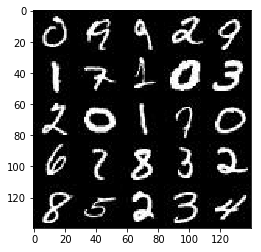

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

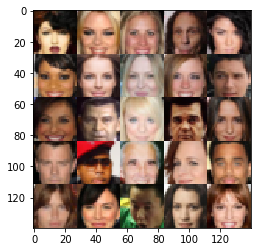

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    image_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='image_input')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    return image_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #x1 = tf.layers.batch_normalization(x1, training=True) #Batch Normalization
        x1 = tf.maximum(alpha * x1, x1) #Leaky ReLU
        #14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True) #Batch Normalization
        x2 = tf.maximum(alpha * x2, x2) #Leaky ReLU
        #7x7x128
        
        x3 = tf.layers.conv2d(x1, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True) #Batch Normalization
        x3 = tf.maximum(alpha * x3, x3) #Leaky ReLU
        #7x7x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        discriminator_logits = tf.layers.dense(flat, 1)
        
        discriminator_output = tf.sigmoid(discriminator_logits)
        
    return discriminator_output, discriminator_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train) #Batch Normalization
        x1 = tf.maximum(alpha * x1, x1) #Leaky ReLU
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train) #Batch Normalization
        x2 = tf.maximum(alpha * x2, x2) #Leaky ReLU
        #14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train) #Batch Normalization
        x3 = tf.maximum(alpha * x3, x3) #Leaky ReLU
        #28x28x128
        
        generator_logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        generator_output = tf.tanh(generator_logits)
        
    return generator_output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                      labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake,
                                                                      labels=tf.zeros_like(d_model_fake)))
    
    discriminator_loss = d_loss_real + d_loss_fake
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_model_fake)))
    
    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    generator_vars = [var for var in t_vars if var.name.startswith('generator')]
    discriminator_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,
                                                                                              var_list=discriminator_vars)
        generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,
                                                                                          var_list=generator_vars)
    
    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    losses = []
    
    _, image_width, image_height, out_channel_dim = data_shape
    input_real, input_z, learning_rate_tensor = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    n_images = 25
    steps = 0
    show_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample Random Noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                # Optmizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               learning_rate_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               learning_rate_tensor: learning_rate}) 
                
                if steps % show_every == 0 :
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0 :
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 0.9682
Epoch 1/2... Discriminator Loss: 0.5694... Generator Loss: 1.5109
Epoch 1/2... Discriminator Loss: 1.6924... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 0.3090... Generator Loss: 2.7896
Epoch 1/2... Discriminator Loss: 0.1886... Generator Loss: 3.1557
Epoch 1/2... Discriminator Loss: 0.1462... Generator Loss: 3.6678
Epoch 1/2... Discriminator Loss: 0.1234... Generator Loss: 4.8347
Epoch 1/2... Discriminator Loss: 0.0810... Generator Loss: 4.9109
Epoch 1/2... Discriminator Loss: 0.0680... Generator Loss: 4.9544
Epoch 1/2... Discriminator Loss: 0.1239... Generator Loss: 3.7826


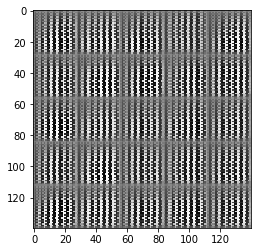

Epoch 1/2... Discriminator Loss: 0.3408... Generator Loss: 2.2076
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 0.7865... Generator Loss: 1.3638
Epoch 1/2... Discriminator Loss: 0.2614... Generator Loss: 2.8407
Epoch 1/2... Discriminator Loss: 0.1978... Generator Loss: 2.9654
Epoch 1/2... Discriminator Loss: 0.2758... Generator Loss: 2.0083
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.8175
Epoch 1/2... Discriminator Loss: 0.2524... Generator Loss: 2.4609
Epoch 1/2... Discriminator Loss: 0.1912... Generator Loss: 2.6267
Epoch 1/2... Discriminator Loss: 0.2995... Generator Loss: 1.8205


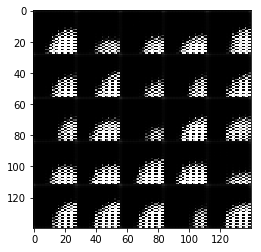

Epoch 1/2... Discriminator Loss: 0.5003... Generator Loss: 1.6585
Epoch 1/2... Discriminator Loss: 0.2536... Generator Loss: 2.2658
Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 1.5585
Epoch 1/2... Discriminator Loss: 0.8245... Generator Loss: 1.1161
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 0.7433


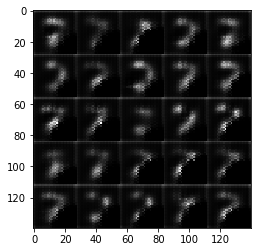

Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.7373


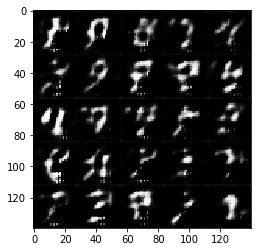

Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.7647
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.7546


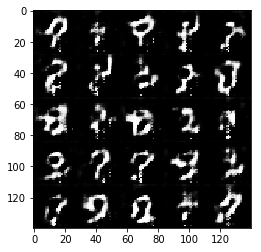

Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7212


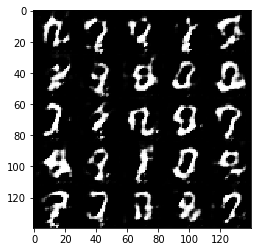

Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.7506
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.7345


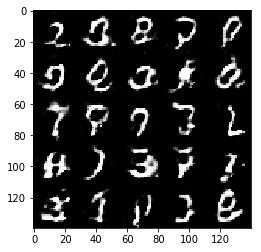

Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.7224
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7212


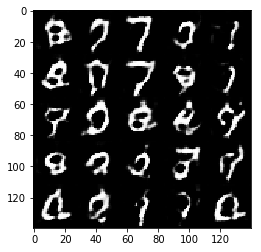

Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 0.7202
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.7493
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.7304


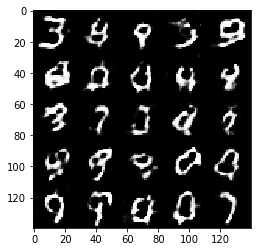

Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.7294
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.7436


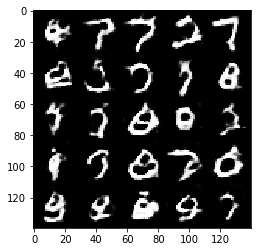

Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 0.7364
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.7245


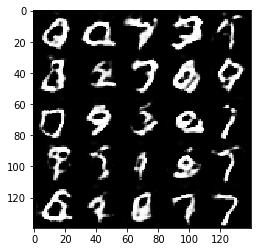

Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.7465


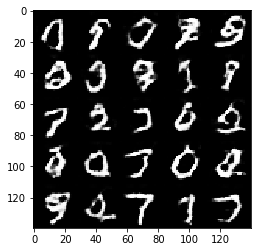

Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.7383


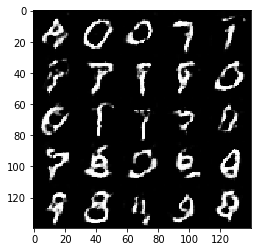

Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.7467


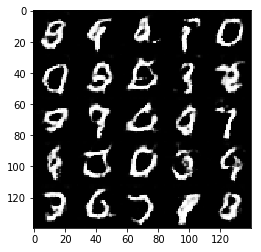

Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.7932
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.7599
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 0.7476


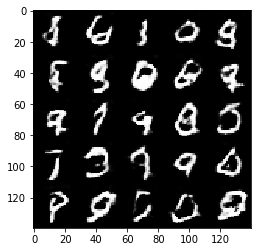

Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.7010


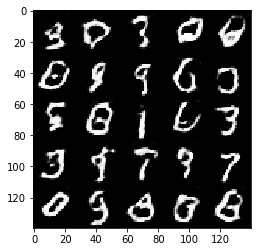

Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.7005
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.7458
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.7323


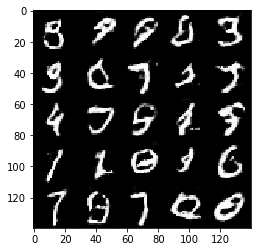

Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.7354


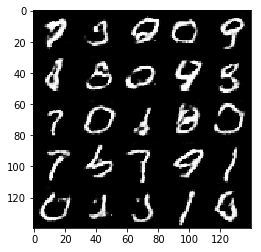

Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.7251
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.8769
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.7375


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#To get better results run with more epochs, but it will take longer.
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8371... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 3.0561
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.2984... Generator Loss: 3.1606
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 4.1092
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 0.2328... Generator Loss: 2.7749


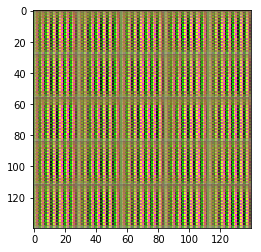

Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 2.0741
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.6324
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.3185
Epoch 1/1... Discriminator Loss: 0.3005... Generator Loss: 2.2124
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 1.8752
Epoch 1/1... Discriminator Loss: 0.3136... Generator Loss: 3.0405
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.7137


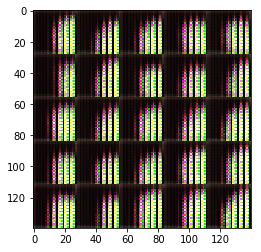

Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 2.3417
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 1.8150
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 2.2385
Epoch 1/1... Discriminator Loss: 0.2190... Generator Loss: 2.4647
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 1.9547
Epoch 1/1... Discriminator Loss: 0.2486... Generator Loss: 2.4259
Epoch 1/1... Discriminator Loss: 0.2493... Generator Loss: 2.3017


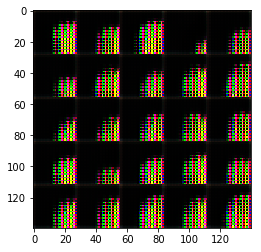

Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 2.2188
Epoch 1/1... Discriminator Loss: 0.3144... Generator Loss: 1.9366
Epoch 1/1... Discriminator Loss: 0.2864... Generator Loss: 2.2830
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 1.8749
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 1.8546
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 1.4670
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.3193
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 1.5019


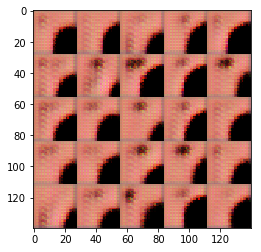

Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.4450
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.1867


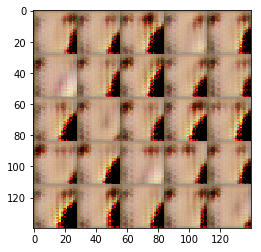

Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8314


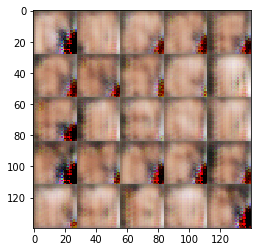

Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7106


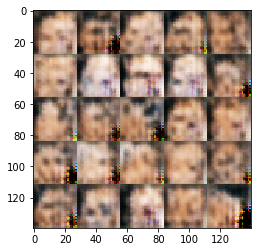

Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8268


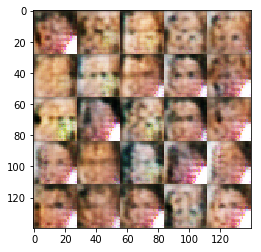

Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6882


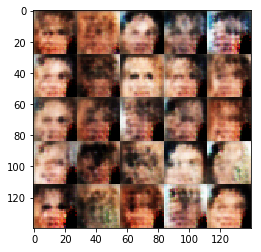

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7386


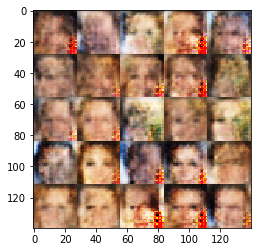

Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6845


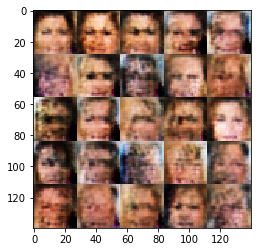

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7031


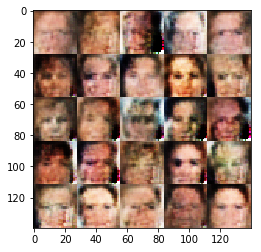

Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6908


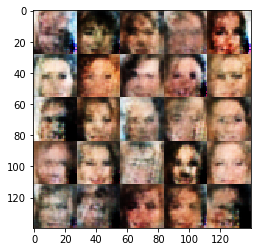

Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6971


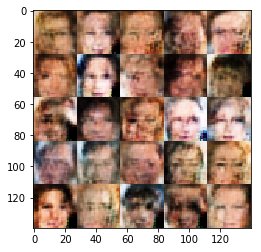

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7714


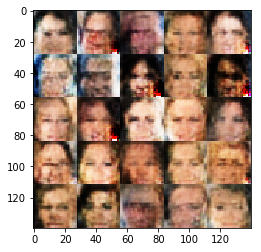

Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7092


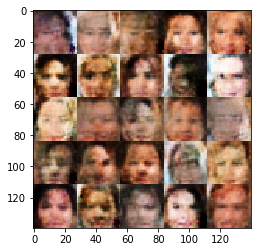

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7464


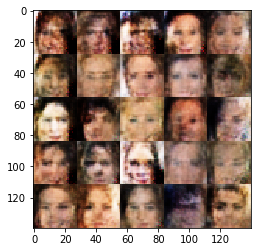

Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.6897


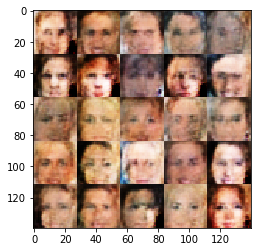

Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6921


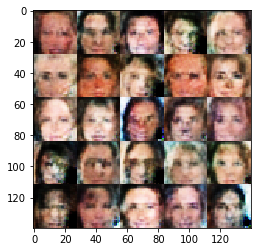

Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7885


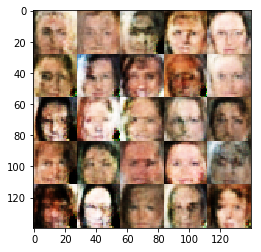

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7402


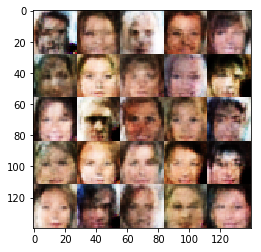

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6700


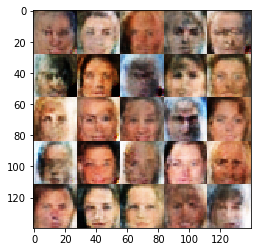

Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6468


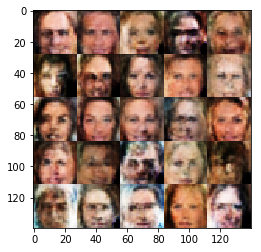

Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6989


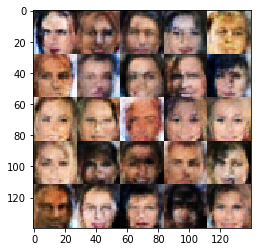

Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7895


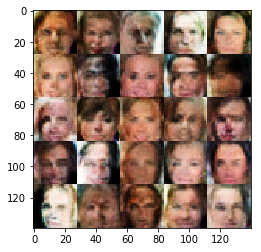

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7074


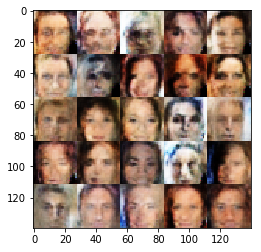

Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6843


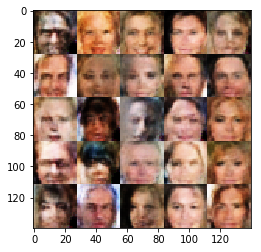

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7232


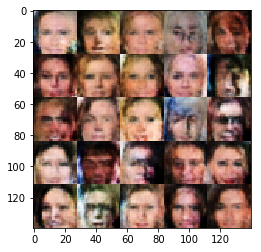

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7549


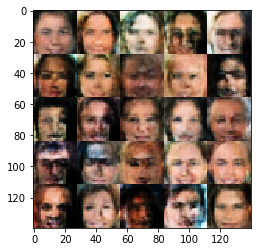

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6800


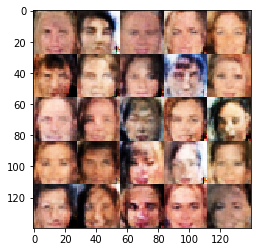

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7241


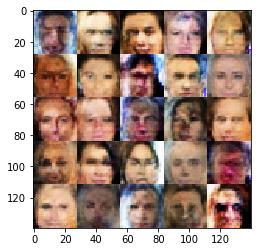

Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6910


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#To get better results run with more epochs, at least 10 epochs, but it will take much longer.
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.